# Reminder to startup the Unity render binary if it is not already running!

In [1]:
import sys
import numpy as np
from IPython.display import HTML, display

class RRT_star_Node:
    def __init__(self, pos):
        self.pos = pos
        self.cost = 0
        self.edges = np.array([])
        self.parent = None

class RRT_star_Graph:
    def __init__(self, nodes=np.array([])):
        self.nodes = nodes
    def add_node(self, node):
        self.nodes = np.append(self.nodes, node)
    def add_edge(self, node1, node2):
        node1.edges = np.append(node1.edges, node2)
        node2.edges = np.append(node2.edges, node1)
    def remove_edge(self, node1, node2):
        node1.edges = np.delete(node1.edges, np.argwhere(node1.edges == node2))
        node2.edges = np.delete(node2.edges, np.argwhere(node2.edges == node1))
        
    def nearest_node(self, v):
        dist = None
        nearest = None
        for node in self.nodes:
            node_dist = np.linalg.norm(v - node.pos)
            if dist is None or node_dist < dist:
                dist = node_dist
                nearest = node
        return nearest

    # Dijkstra
    def shortest_path_parents(self, source):
        visited = {}
        dist = {}
        parent = {}
        for n in self.nodes:
            visited[n] = False
            parent[n] = None
            dist[n] = [sys.maxsize]
        
        dist[source] = 0
        queue = [source]
        while queue:
            curr = queue.pop(0)
            for n in curr.edges:
                if not visited[n]:
                    queue.append(n)
                    new_dist = dist[curr] + np.linalg.norm(curr.pos - n.pos)
                    if dist[n] > new_dist:
                        parent[n] = curr
                        dist[n] = new_dist
            visited[curr] = True
            
        # helper, assumes the parent exists

        return parent
    
    # goes up the parent chain up to source
    def get_path(self, parent, curr, path):
        if parent[curr]:
            path = self.get_path(parent, parent[curr], path)
        path = np.append(path, curr)
        return path












Start pos: [  0. -15.  -2.]
Start attitude: [ 0.          0.         -1.57079633]
Target pose: [  9.         -24.          -2.          -1.57079633]
Nearest node to the target pos, to grab the path from:  [  8.33759529 -22.9756492   -2.        ]

Closest node pos: [  8.33759529 -22.9756492   -2.        ]
Heading to  [  0. -15.  -2.] , from  [  0. -15.  -2.]
Heading to  [  5.83098753 -18.5515409   -2.        ] , from  [  0. -15.  -2.]
Heading to  [  5.81932607 -22.95471354  -2.        ] , from  [  5.82318945 -18.55628837  -2.00392499]
Heading to  [  7.25049363 -22.20810049  -2.        ] , from  [  5.8177437  -22.94521556  -1.99815984]
Heading to  [  7.81008419 -22.67513591  -2.        ] , from  [  7.24370117 -22.21506483  -2.00153363]
Heading to  [  8.33759529 -22.9756492   -2.        ] , from  [  7.80759055 -22.66849398  -2.00135069]
Final pose [  8.34 -22.98  -1.99   0.  ]


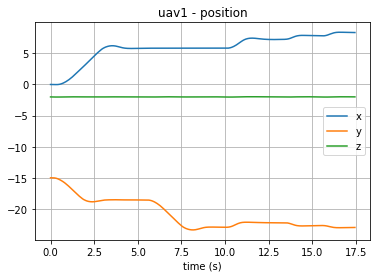

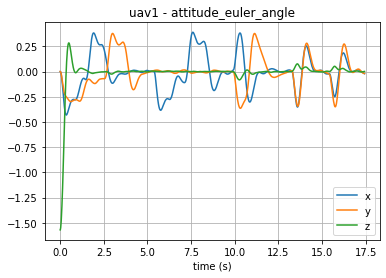

In [5]:
#!/usr/bin/env python
# coding: utf-8
%matplotlib inline
%reload_ext autoreload
%autoreload 2
sys.path.insert(0, '../')
from flightgoggles.env import *

def gen_rand_pos(bound1, bound2):
    rand_pos = bound1 + (bound2 - bound1) * [np.random.random_sample(),
                                             np.random.random_sample(),
                                             np.random.random_sample()]
    return rand_pos

def willCollide(env, start_pose, end_pose):
    EPSILON = 0.01
    env.set_state_vehicle(vehicle_id="uav_collision_tester",
                          position=start_pose[:3],
                          attitude_euler_angle=np.array([0., 0., start_pose[3]]))
    # proceed_waypoint -> fix a location to go toward; duration is the delta time in PID loop
    curr_pos = start_pose[:3]
    while np.linalg.norm(curr_pos - end_pose[:3]) > EPSILON:
        collided = env.proceed_waypoint(vehicle_id="uav_collision_tester", waypoint_command=end_pose, duration=0.01)
        curr_pos = env.get_state("uav_collision_tester")["position"]
        if collided:
            return True
    return False

if __name__ == "__main__":
    env = flightgoggles_env(
        cfg_dir="../config",
        cfg_fgclient="FlightGogglesClient_rrt_brancher.yaml",
        cfg_uav="multicopterDynamicsSim.yaml")
    
    start_pos = np.array([0, -15., -2.])
    start_att = np.array([0.,0.,-np.pi/2])
    
    target_pos = start_pos + np.array([9, -9., 0.]) #np.array([9., -15., -2.])
    target_att = start_att + np.array([0., 0., 0.]) #np.array([0., 0., 0.])
    target_pose = np.append(target_pos, target_att[2])
    
    start_node = RRT_star_Node(start_pos)
    
    # position and attitude -> pose
    print("Start pos: {}".format(start_pos))
    print("Start attitude: {}".format(start_att))
    print("Target pose: {}".format(target_pose))
    
    # ONLY PUTTING IN THE START NODE
    graph = RRT_star_Graph(np.array([start_node]))
    
    trials = 50
    search_radius = 2.5 * (np.log(trials) / trials)**(1/3) # 3 dimensins
    for _ in range(trials):
        
        rand_pos = gen_rand_pos(start_pos, target_pos)
        nearest_node = graph.nearest_node(rand_pos)

        # ignore delta steps for now
        if not willCollide(env, np.append(nearest_node.pos, 0.),
                                np.append(rand_pos, 0.)):
            new_node = RRT_star_Node(rand_pos)
            new_node.cost = nearest_node.cost + np.linalg.norm(nearest_node.pos - new_node.pos)
            
            final_neighbor = nearest_node
            for node in graph.nodes:
                if np.linalg.norm(node.pos - new_node.pos) < search_radius:
                    agg_cost = node.cost + np.linalg.norm(node.pos - new_node.pos)
                    if agg_cost < new_node.cost and not willCollide(env, np.append(new_node.pos, 0.),
                                                                         np.append(node.pos, 0.)):
                        final_neighbor = node
                        new_node.cost = agg_cost
                        
            for node in graph.nodes:
                if np.linalg.norm(node.pos - new_node.pos) < search_radius:
                    agg_cost = new_node.cost + np.linalg.norm(node.pos - new_node.pos)
                    if agg_cost < node.cost and not willCollide(env, np.append(new_node.pos, 0.),
                                                                     np.append(node.pos, 0.)):
                        if node.parent:
                            graph.remove_edge(node, node.parent)
                        node.cost = agg_cost
                        node.parent = new_node
                        for n in node.edges:
                            n.cost = node.cost + np.linalg.norm(node.pos - n.pos)
                        graph.add_edge(new_node, node)
            
            graph.add_node(new_node)
            new_node.parent = final_neighbor
            graph.add_edge(final_neighbor, new_node)
    
    parent = graph.shortest_path_parents(start_node)
    nearest_node = graph.nearest_node(target_pos)
    print("Nearest node to the target pos, to grab the path from: ", nearest_node.pos)
    
    path = graph.get_path(parent, nearest_node, np.array([]))
    env.close()
    #-------------------------
    env = flightgoggles_env(
        cfg_dir="../config",
        cfg_fgclient="FlightGogglesClient_testing.yaml",
        cfg_uav="multicopterDynamicsSim.yaml")
    # follow the path with uav1
    env.set_state_vehicle(vehicle_id="uav1",
                          position=start_pos,
                          attitude_euler_angle=start_att)

    
    print("Closest node pos: {}".format(nearest_node.pos))
        
    # proceed_waypoint -> fix a location to go toward; duration is the delta time in PID loop
    #for j in range(600):
    curr_pos = start_pos
    curr_vel = env.get_state("uav1")["velocity"]
    stop = False
    for node in path: 
        print("Heading to ", node.pos, ", from ", curr_pos)
        while np.linalg.norm(curr_pos - node.pos) > 0.01 or np.sum(curr_vel**2) > 0.01:
            collided = env.proceed_waypoint(vehicle_id="uav1",
                                            # need to read up more on attitude and path finding to find better value
                                            # shuold add attitude to wayp_comm?
                                            waypoint_command=node.pos,
                                            duration=0.01)
            curr_pos = env.get_state("uav1")["position"]
            curr_vel = env.get_state("uav1")["velocity"]
            if collided:
                stop = True
                break
        if stop:
            break
    
    env.plot_state(vehicle_id="uav1", attribute="position")
    env.plot_state(vehicle_id="uav1", attribute="attitude_euler_angle")
    #env.save_logs(vehicle_id="uav1", save_dir="data/")
    #img = env.get_camera_image(camera_id="cam1")
   # print(img[-1]["timestamp"])
    
    with np.printoptions(precision=2, suppress=True):
        print("Final pose", np.append(env.get_state("uav1")["position"],
                                      env.get_state("uav1")["attitude_euler_angle"][2]))

    ani_set = env.plot_state_video()
    
    if "cam1" in ani_set.keys():
        display(HTML(ani_set["cam1"].to_html5_video()))
    env.close()

[  0. -15.  -2.]
[  5.83098753 -18.5515409   -2.        ]
[  5.81932607 -22.95471354  -2.        ]
[  7.25049363 -22.20810049  -2.        ]
[  7.81008419 -22.67513591  -2.        ]
[  8.33759529 -22.9756492   -2.        ]


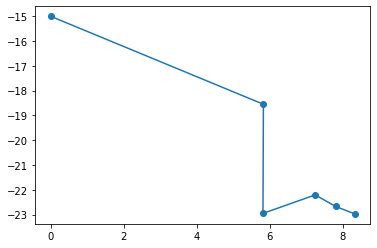

In [6]:
import matplotlib.pyplot as plt
x = np.array([])
y = np.array([])
for n in path:
    print(n.pos)
    x = np.append(x, n.pos[0])
    y = np.append(y, n.pos[1])
plt.plot(x, y, marker='o')